## Recursive feature addition with Feature-engine

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    RecursiveFeatureAddition,
    DropConstantFeatures,
    DropDuplicateFeatures,)

## Classification

In [26]:
data = pd.read_csv('dataset_1.csv')
data.shape

(50000, 301)

In [27]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_292,var_293,var_294,var_295,var_296,var_297,var_298,var_299,var_300,target
0,0,0,0.0,0.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
1,0,0,0.0,3.00,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
2,0,0,0.0,5.88,0.0,0,0,0,0,0,...,0.0,0,0,3,0,0,0,0.0,67772.7216,0
3,0,0,0.0,14.10,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0
4,0,0,0.0,5.76,0.0,0,0,0,0,0,...,0.0,0,0,0,0,0,0,0.0,0.0000,0


**Important**

Select the features by **examining only the training set** to **avoid overfit.**

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((35000, 300), (15000, 300))

### Recursive Feature Addition

**Remove constant, quasi-constant and duplicated!**

In [29]:
pipe = Pipeline([
    ('constant', DropConstantFeatures(tol=0.998)),
    ('duplicated', DropDuplicateFeatures()),])
pipe.fit(X_train)
X_train = pipe.transform(X_train)  # remove features
X_test = pipe.transform(X_test)
X_train.shape, X_test.shape

((35000, 152), (15000, 152))

In [30]:
model = GradientBoostingClassifier(  # the ML model for which we want to select features
    n_estimators=10,
    max_depth=2,
    random_state=10,)

In [31]:
rfa = RecursiveFeatureAddition(  # Setup the RFA selector
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='roc_auc',  # the metric we want to evalute
    threshold=0.0001,  # the minimum performance increase needed to select a feature
    cv=2,)  # cross-validation
rfa.fit(X_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingClassifier(max_depth=2,
                                                              n_estimators=10,
                                                              random_state=10),
                         threshold=0.0001)

**Performance of model trained using all features!**

In [32]:
rfa.initial_model_performance_

0.7989005422137565

**Importance of all features based of initial model!**

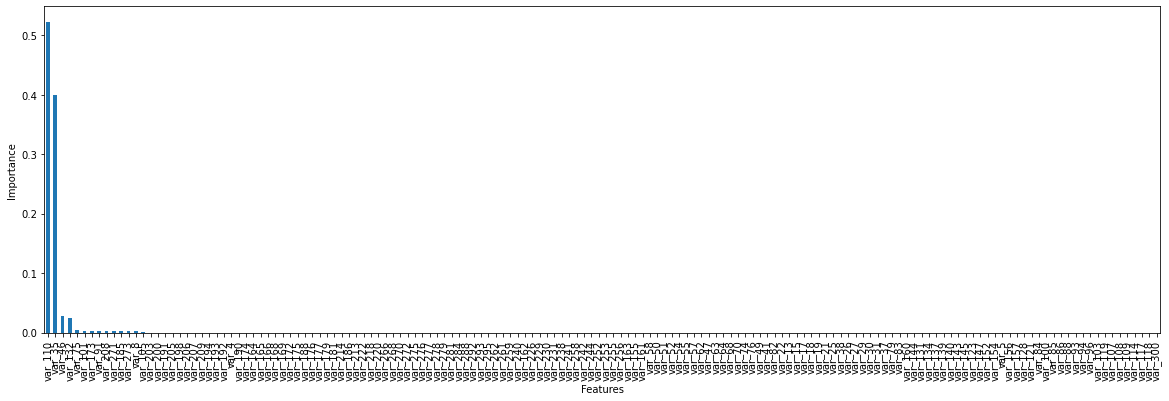

In [33]:
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

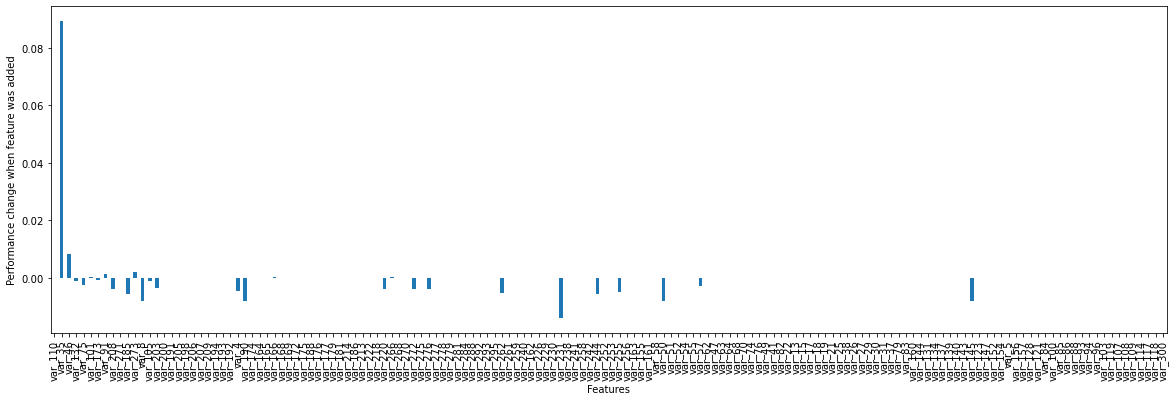

In [34]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

**Very few features cause a big increase** in model performance when added.

**Number of features that will be removed!**

In [35]:
len(rfa.features_to_drop_)

144

**Select features!**

In [36]:
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)

**For comparison, we build a model with the selected features only!**

In [38]:
model_final = GradientBoostingClassifier(
    n_estimators=10, max_depth=2, random_state=10)
model_final.fit(X_train, y_train)  # fit the model with the selected features
y_pred_test = model_final.predict_proba(X_test)[:, 1]  # make predictions
roc_final = roc_auc_score(y_test, y_pred_test)  # calculate roc-auc
print('Test selected features ROC AUC=%f' % (roc_final))

Test selected features ROC AUC=0.802329


The **ROC-AUC is very similar** to that of the model trained using all the variables.

## Regression

In [40]:
data = pd.read_csv('HousingPrices_train.csv')
data.shape

(1460, 81)

**For simplicity I will use only numerical variables select numerical columns:**

In [42]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['Id','SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((1022, 36), (438, 36))

**Fill missing values!**

In [44]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Recursive Feature Addition

**The model for which we want to select features!**

In [45]:
model = GradientBoostingRegressor(
    n_estimators=10, max_depth=4, random_state=10)
rfa = RecursiveFeatureAddition(  # Setup the RFA selector
    variables=None,  # automatically evaluate all numerical variables
    estimator=model,  # the ML model
    scoring='r2',  # the metric we want to evalute
    threshold=0.001,  # the minimum performance increase needed to select a feature
    cv=2,)  # cross-validation
rfa.fit(X_train, y_train)

RecursiveFeatureAddition(cv=2,
                         estimator=GradientBoostingRegressor(max_depth=4,
                                                             n_estimators=10,
                                                             random_state=10),
                         scoring='r2', threshold=0.001)

**Performance of model trained using all features!**

In [46]:
rfa.initial_model_performance_

0.6821660665052749

**Importance of all features based of initial model!**

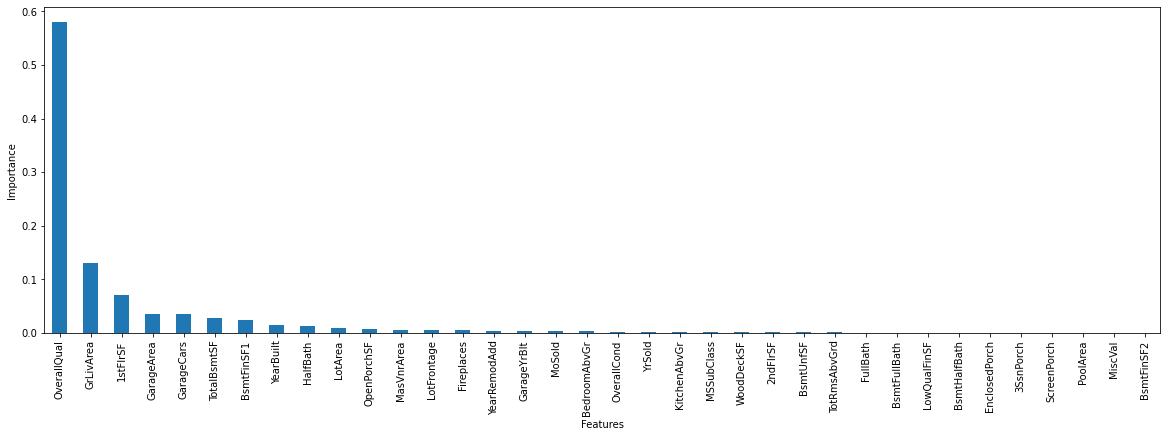

In [47]:
rfa.feature_importances_.plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

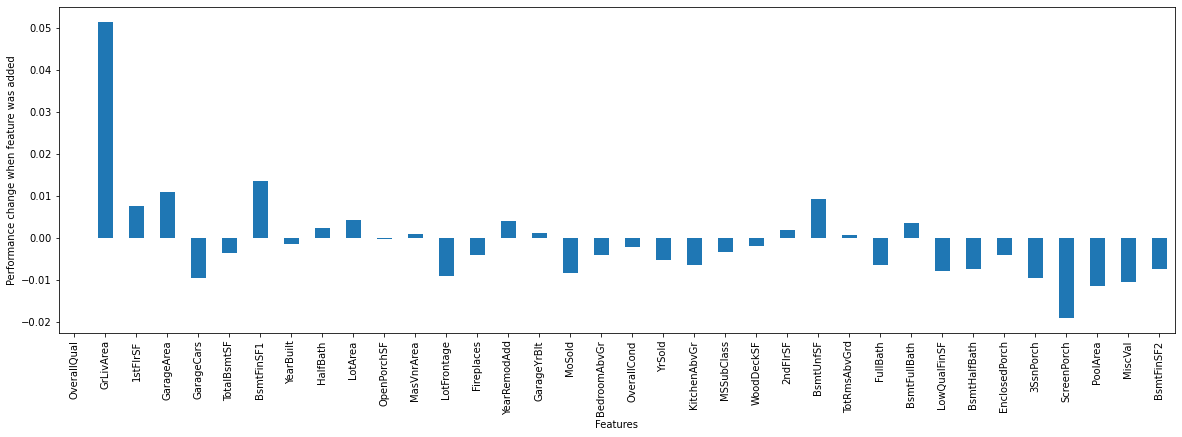

In [48]:
pd.Series(rfa.performance_drifts_).plot.bar(figsize=(20,6))
plt.xlabel('Features')
plt.ylabel('Performance change when feature was added')
plt.show()

**Number of features that will be removed!**

In [49]:
len(rfa.features_to_drop_)

24

In [50]:
X_train = rfa.transform(X_train)
X_test = rfa.transform(X_test)
X_train.shape, X_test.shape

((1022, 12), (438, 12))

**Test the performance of the model built on the selected features! Build initial model**

In [51]:
model_final = GradientBoostingRegressor(n_estimators=10, max_depth=4, random_state=10)
model_final.fit(X_train, y_train)# fit the model with the selected features
y_pred_test = model_final.predict(X_test)# make predictions
r2_final = r2_score(y_test, y_pred_test)# calculate roc-auc
print('Test selected features r2 = %f' % (r2_final))

Test selected features r2 = 0.735100


The model trained using less features shows a **similar performance to the original one.**